In [44]:
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from scipy.stats import mannwhitneyu, kruskal, spearmanr

In [45]:
def extract_subject_data(file_path):
    subject_data = {}
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    # Regular expression to capture subject identifiers like 1069, 19, 201, etc.
    subject_pattern = re.compile(r"^(\d+):")
    
    current_subject = None
    for line in lines:
        match = subject_pattern.match(line.strip())
        
        if match:
            current_subject = match.group(1)  # subject ID
            subject_data[current_subject] = {}
        elif current_subject:
            # Extracting the values for accuracy, precision, recall, F1-score, and ROC AUC
            if "accuracy" in line:
                subject_data[current_subject]['accuracy'] = float(line.split(":")[1].strip())
            elif "precision" in line:
                subject_data[current_subject]['precision'] = float(line.split(":")[1].strip())
            elif "recall" in line:
                subject_data[current_subject]['recall'] = float(line.split(":")[1].strip())
            elif "F1-score" in line:
                subject_data[current_subject]['F1-score'] = float(line.split(":")[1].strip())
            elif "ROC AUC" in line:
                subject_data[current_subject]['ROC AUC'] = float(line.split(":")[1].strip())
    
    return subject_data

In [46]:
# Function to perform the tests
def compare_metrics(file_path_1, file_path_2):
    # Extract data from both files
    data_1 = extract_subject_data(file_path_1)
    data_2 = extract_subject_data(file_path_2)
    
    # Prepare a dictionary to store comparison results for each metric
    comparison_results = {}
    
    # Compare metrics
    for metric in ['accuracy', 'precision', 'recall', 'F1-score', 'ROC AUC']:
        # Extract values for the current metric from both data sets
        metric_data_1 = [subject_data[metric] for subject_data in data_1.values()]
        metric_data_2 = [subject_data[metric] for subject_data in data_2.values()]
        
        # Mann-Whitney U Test
        u_statistic, p_value_mannwhitney = mannwhitneyu(metric_data_1, metric_data_2)
        
        # Kruskal-Wallis Test
        h_statistic, p_value_kruskal = kruskal(metric_data_1, metric_data_2)
        
        # Store the results in the comparison_results dictionary
        comparison_results[metric] = {
            'Mann-Whitney U Test': {
                'U-statistic': f"{u_statistic:.3f}",
                'p-value': f"{p_value_mannwhitney:.3f}"
            },
            'Kruskal-Wallis Test': {
                'H-statistic': f"{h_statistic:.3f}",
                'p-value': f"{p_value_kruskal:.3f}"
            }
        }
    
    return comparison_results

In [50]:
# data_1 = "./metrics/SVM/scaled_rbf_mfcc_20_no_pitch_rand.txt"
# data_2 = "./metrics/SVM/scaled_rbf_mfcc_20_pitch_rand.txt"

# data_1 = "./metrics/SVM/rbf_pca_mfcc_20_no_pitch_rand.txt"
# data_2 = "./metrics/SVM/rbf_pca_mfcc_20_pitch_rand.txt"

# data_1 = "./metrics/SVM/scaled_rbf_mfcc_20_no_pitch_rand.txt"
# data_2 = "./metrics/SVM/rbf_pca_mfcc_20_no_pitch_rand.txt"

data_1 = "./metrics/HMM/diag_5_mfcc_20_no_pitch_rand.txt"
data_2 = "./metrics/HMM/diag_5_mfcc_20_pitch_rand.txt"

# data_2 = "./metrics/HMM/diag_5_mfcc_20_pitch_rand.txt"

results = compare_metrics(data_1, data_2)

for metric, result in results.items():
    print(f"Metric: {metric}")
    for test, values in result.items():
        print(f"  {test}:")
        # Access 'U-statistic' for Mann-Whitney U Test, and 'H-statistic' for Kruskal-Wallis Test
        statistic_key = 'U-statistic' if 'Mann-Whitney' in test else 'H-statistic'
        print(f"    {statistic_key} = {values[statistic_key]}")
        print(f"    p-value = {values['p-value']}")

Metric: accuracy
  Mann-Whitney U Test:
    U-statistic = 189.500
    p-value = 0.787
  Kruskal-Wallis Test:
    H-statistic = 0.081
    p-value = 0.776
Metric: precision
  Mann-Whitney U Test:
    U-statistic = 169.500
    p-value = 0.417
  Kruskal-Wallis Test:
    H-statistic = 0.681
    p-value = 0.409
Metric: recall
  Mann-Whitney U Test:
    U-statistic = 217.000
    p-value = 0.655
  Kruskal-Wallis Test:
    H-statistic = 0.212
    p-value = 0.645
Metric: F1-score
  Mann-Whitney U Test:
    U-statistic = 194.000
    p-value = 0.882
  Kruskal-Wallis Test:
    H-statistic = 0.026
    p-value = 0.871
Metric: ROC AUC
  Mann-Whitney U Test:
    U-statistic = 193.500
    p-value = 0.871
  Kruskal-Wallis Test:
    H-statistic = 0.031
    p-value = 0.860


### Feature Testing

In [32]:
def scale_features(data_dict):
    """
    Scales the data in a dictionary using StandardScaler.
    
    Parameters:
        data_dict (dict): Dictionary where each key is a subject, and the value is a 2D array 
                          (samples x features).
                          
    Returns:
        dict: A new dictionary with scaled data, maintaining the same structure as the input.
    """
    # Combine all data into a single array
    all_samples = np.vstack(list(data_dict.values()))  # Shape: (total_samples, num_features)

    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(all_samples)  # Shape: (total_samples, num_features)

    # Split scaled data back into original structure
    split_indices = np.cumsum([len(samples) for samples in data_dict.values()])[:-1]
    scaled_subjects = np.split(scaled_data, split_indices)

    # Reconstruct the dictionary with scaled data
    scaled_data_dict = {key: scaled_subjects[i] for i, key in enumerate(data_dict.keys())}

    return scaled_data_dict

In [57]:
features = "mfcc_20_no_pitch_1000_rand"

with open(f"../../data/extracted_features_v2/{features}.pickle", "rb") as file:
   mfcc_stats_dict = pickle.load(file)

if "pca" not in features:
   print("scaling performed")
   mfcc_stats_dict = scale_features(mfcc_stats_dict)

for reader in mfcc_stats_dict.keys():
    print(f"reader: {reader} | # samples {len(mfcc_stats_dict[reader])}")

scaling performed
reader: 1069 | # samples 1000
reader: 19 | # samples 1000
reader: 201 | # samples 1000
reader: 250 | # samples 1000
reader: 254 | # samples 999
reader: 26 | # samples 1000
reader: 27 | # samples 1000
reader: 289 | # samples 1000
reader: 298 | # samples 1000
reader: 311 | # samples 1000
reader: 32 | # samples 1000
reader: 3240 | # samples 1000
reader: 39 | # samples 1000
reader: 40 | # samples 1000
reader: 4297 | # samples 1000
reader: 60 | # samples 1000
reader: 78 | # samples 1000
reader: 7800 | # samples 1000
reader: 83 | # samples 1000
reader: 87 | # samples 1000


In [58]:
def spearman_correlation_test(speaker_data):
    """
    Runs a Spearman rank correlation test on the features of each speaker
    and across all speakers.

    Args:
    - speaker_data (dict): A dictionary where keys are speaker identifiers
                            and values are 2D numpy arrays (instances x features).
    
    Returns:
    - speaker_corrs (dict): A dictionary with Spearman correlation results 
                             for each speaker.
    - all_speakers_corr (float): Spearman correlation coefficient for all speakers combined.
    """
    # Dictionary to store individual speaker correlations
    speaker_corrs = {}

    # Calculate Spearman correlation for each speaker
    for speaker, data in speaker_data.items():
        # Perform the Spearman correlation on the features for each speaker
        corr, _ = spearmanr(data, axis=0)  # Correlation matrix for features
        speaker_corrs[speaker] = corr

    # To calculate correlation across all speakers, concatenate all their feature matrices
    # Assuming that the speakers' data matrices have the same number of features
    all_speakers_data = np.vstack(list(speaker_data.values()))
    
    # Compute the correlation for the combined data
    all_speakers_corr, _ = spearmanr(all_speakers_data, axis=0)
    
    return speaker_corrs, all_speakers_corr

def plot_correlation_matrix(corr_matrix, title="Correlation Matrix"):
    """
    Plots a heatmap of the given correlation matrix.

    Args:
    - corr_matrix (2D array): The correlation matrix to plot.
    - title (str): The title of the heatmap plot. Default is "Correlation Matrix".
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
    plt.title(title)
    plt.show()

def plot_correlation_matrix_scatter(corr_matrix, title="Correlation Matrix Scatter Plot"):
    """
    Plots a scatter plot of the given correlation matrix.

    Args:
    - corr_matrix (2D array): The correlation matrix to plot.
    - title (str): The title of the scatter plot. Default is "Correlation Matrix Scatter Plot".
    """
    # Get the indices of the upper triangle of the correlation matrix (to avoid redundant points)
    n = corr_matrix.shape[0]
    x, y = np.triu_indices(n, k=1)
    
    # Get the correlation values for the upper triangle
    corr_values = corr_matrix[x, y]

    # Plot the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, c=corr_values, cmap='coolwarm', s=50, edgecolor='k', alpha=0.7)
    plt.colorbar(label="Spearman Correlation")
    plt.title(title)
    plt.xlabel("Feature Index 1")
    plt.ylabel("Feature Index 2")
    plt.show()

In [59]:
speaker_corrs, all_speakers_corr = spearman_correlation_test(mfcc_stats_dict)

# Print results for each speaker
for speaker, corr_matrix in speaker_corrs.items():
    print(f"Spearman Correlation Matrix for {speaker}:")
    print(corr_matrix)

# Print the overall correlation for all speakers combined
print("Spearman Correlation Matrix for All Speakers Combined:")
print(all_speakers_corr)

Spearman Correlation Matrix for 1069:
[[ 1.          0.08577322 -0.34557452 ... -0.28711864 -0.06493787
  -0.26494675]
 [ 0.08577322  1.         -0.4077403  ... -0.11482292 -0.03799546
   0.06604491]
 [-0.34557452 -0.4077403   1.         ...  0.26417652  0.05024015
   0.06875607]
 ...
 [-0.28711864 -0.11482292  0.26417652 ...  1.          0.08782898
   0.16041219]
 [-0.06493787 -0.03799546  0.05024015 ...  0.08782898  1.
   0.1433674 ]
 [-0.26494675  0.06604491  0.06875607 ...  0.16041219  0.1433674
   1.        ]]
Spearman Correlation Matrix for 19:
[[ 1.          0.02348522 -0.52370077 ... -0.33082903 -0.29924578
  -0.36354442]
 [ 0.02348522  1.         -0.48804086 ... -0.03399463  0.02355474
   0.09273135]
 [-0.52370077 -0.48804086  1.         ...  0.19973654  0.24782121
   0.10420666]
 ...
 [-0.33082903 -0.03399463  0.19973654 ...  1.          0.04689146
   0.29040161]
 [-0.29924578  0.02355474  0.24782121 ...  0.04689146  1.
   0.11395669]
 [-0.36354442  0.09273135  0.10420666 ...

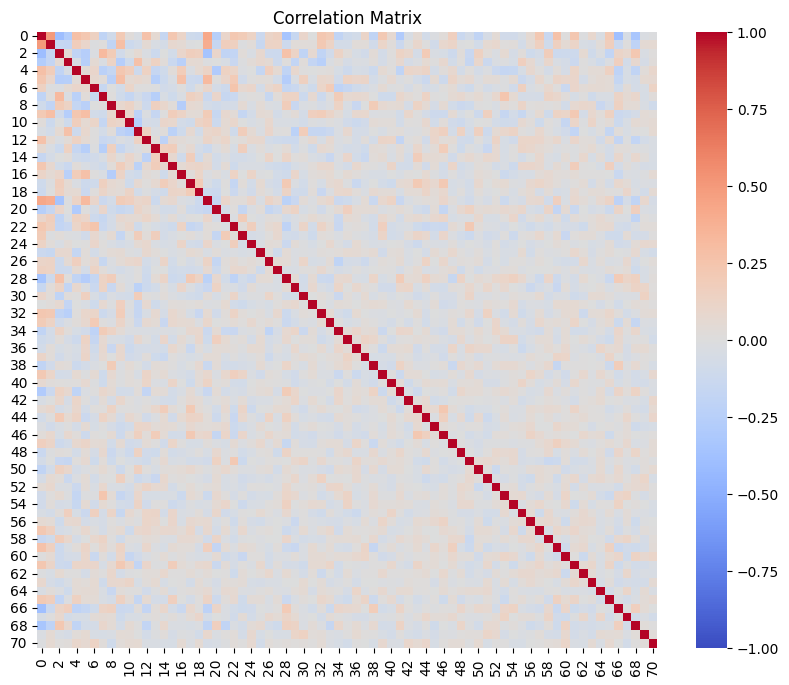

In [55]:
plot_correlation_matrix(speaker_corrs["19"])

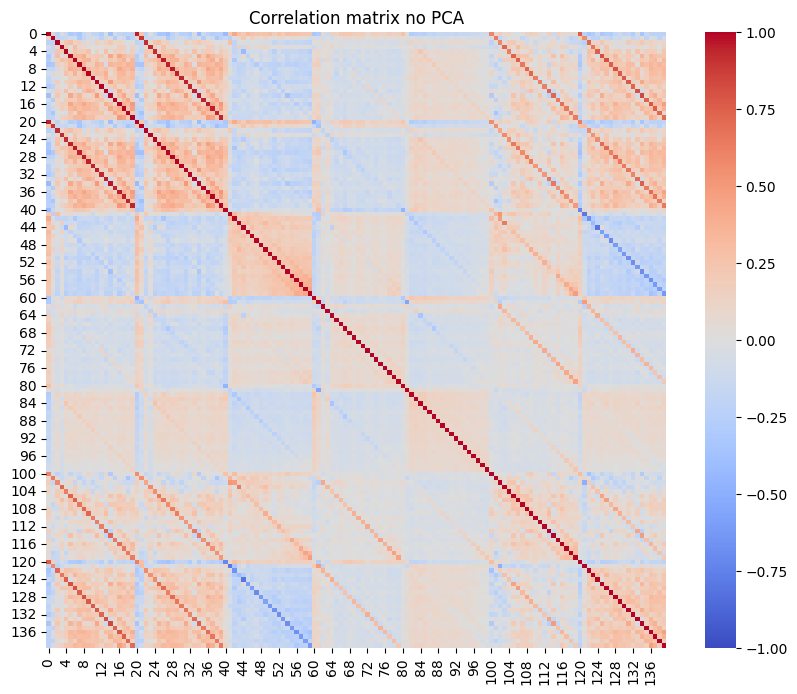

In [60]:
plot_correlation_matrix(all_speakers_corr, title="Correlation matrix no PCA")

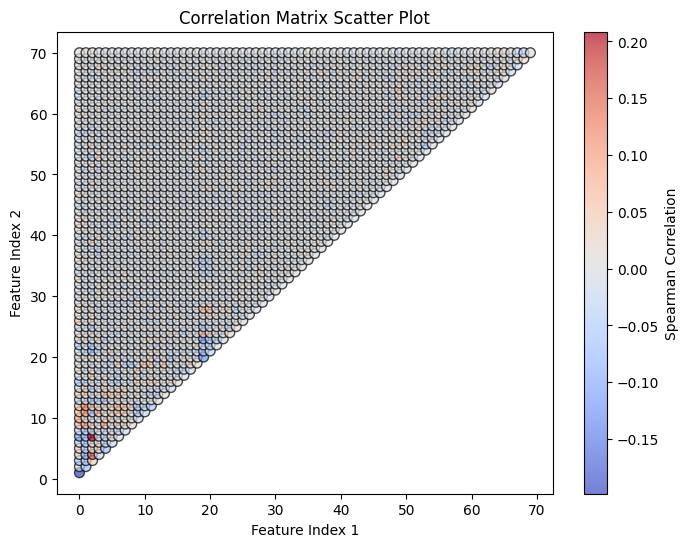

In [41]:
plot_correlation_matrix_scatter(all_speakers_corr)